# Consumption prediction
### Author : Nicolas Lacroix (https://github.com/NicolasLacroix)

Licence : [Apache License 2.0]

This notebook uses [consumption.ipynb] and [meteorology.ipynb].

[Apache License 2.0]: https://github.com/NicolasLacroix/data-representation/blob/master/LICENSE

[consumption.ipynb]: https://github.com/NicolasLacroix/data-representation/blob/master/notebooks/consumption.ipynb
[meteorology.ipynb]: https://github.com/NicolasLacroix/data-representation/blob/master/notebooks/meteorology.ipynb

In [65]:
import torch
import torch.nn as nn

## I. Data

### Importing data

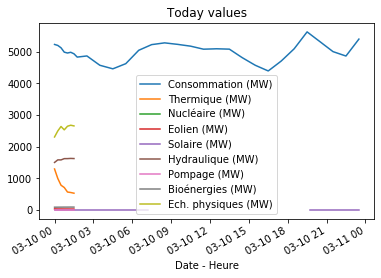

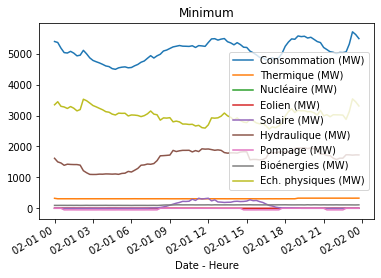

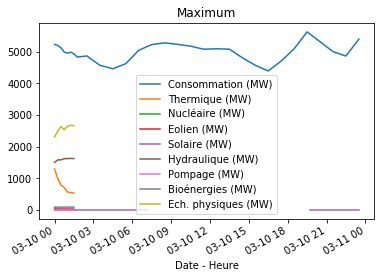

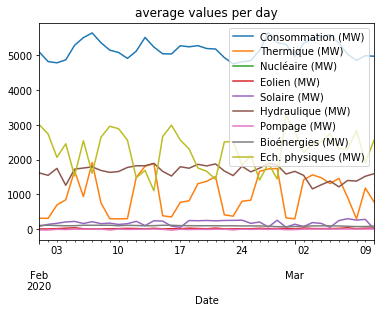

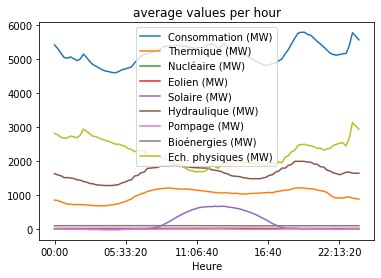

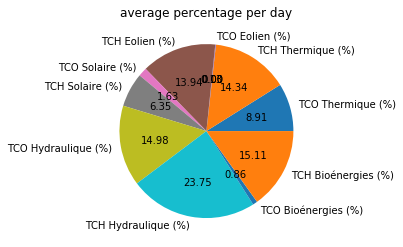

(115233, 81)
(29003, 18)
datetime64[ns, Europe/Paris]
datetime64[ns, Europe/Paris]
datetime64[ns]


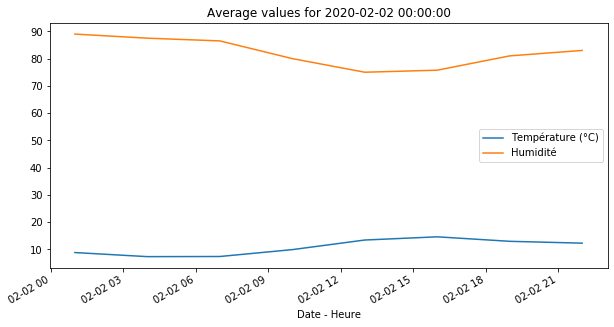

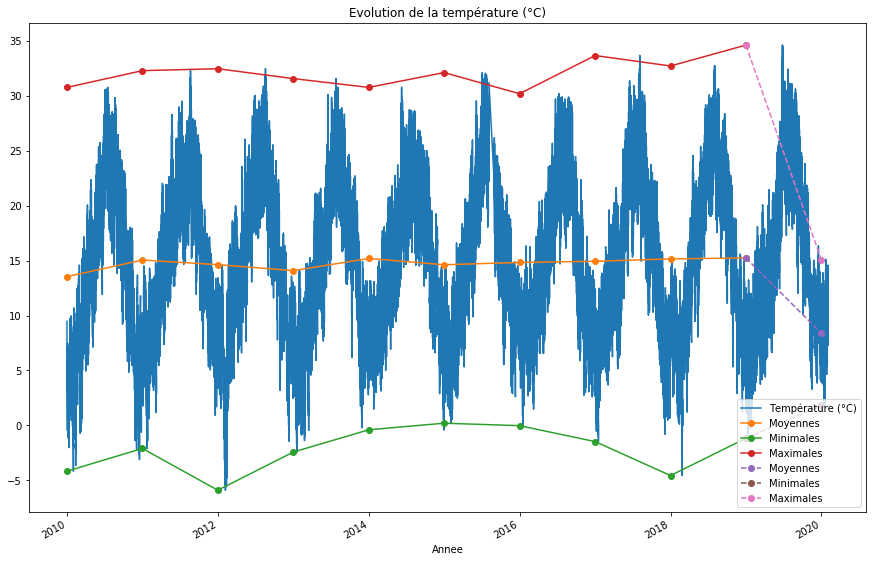

In [66]:
%run consumption.ipynb # import data
%run meteorology.ipynb # import data_meteo

### Processing data

In [67]:
# checking date's format
print(data_meteo['Date'].dtypes == data['Date'].dtypes)
print(data['Date'].dtypes == data_meteo['Date'].dtypes)

True
True


## II. Prediction

In [68]:
TRAIN_SPLIT = 240 # size of the training dataset
NB_DAYS = 10 # number of days to be predicted
BATCH_SIZE = 3
NB_FEATURES = 10

### Training dataset

In [69]:
data_train = pd.merge(data, data_meteo, on=['Date - Heure', 'Date', 'Heure']).drop(['Consommation (MW)'], axis=1).iloc[:NB_FEATURES]
print(data_train.shape)
data_train = data_train.fillna(0)
# final training dataset
data_train.head()

(10, 45)


,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),...,Temps présent,Pression station,Rafales sur une période,Periode de mesure de la rafale,Précipitations dans la dernière heure,Précipitations dans les 3 dernières heures,Précipitations dans les 6 dernières heures,Précipitations dans les 12 dernières heures,Type de tendance barométrique.1,Température (°C)
0,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-02-01,01:00:00,2020-02-01 01:00:00+01:00,308.0,0.0,6.0,0.0,...,0.666667,98845.0,5.300,-10.0,0.000000,0.000000,0.000000,0.000000,4.00,9.250
1,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-02-01,04:00:00,2020-02-01 04:00:00+01:00,308.0,0.0,5.0,0.0,...,0.666667,98797.5,3.675,-10.0,0.000000,0.000000,0.000000,0.000000,7.50,9.000
2,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-02-01,07:00:00,2020-02-01 07:00:00+01:00,308.0,0.0,5.0,0.0,...,1.500000,98795.0,4.875,-10.0,0.000000,0.000000,0.000000,0.000000,4.75,8.325
3,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-02-01,10:00:00,2020-02-01 10:00:00+01:00,308.0,0.0,3.0,224.0,...,1.000000,98917.5,5.075,-10.0,0.000000,0.000000,0.000000,0.000000,3.00,11.000
4,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-02-01,13:00:00,2020-02-01 13:00:00+01:00,308.0,0.0,1.0,199.0,...,16.000000,98902.5,4.400,-10.0,0.033333,0.033333,0.033333,0.033333,4.75,12.600


### Target dataset

In [70]:
target_data = pd.merge(data, data_meteo, on=['Date - Heure', 'Date', 'Heure'])['Consommation (MW)'].iloc[:NB_FEATURES]
target_data = target_data.fillna(0)

In [71]:
# normalizing data
"""target_data_mean = target_data.mean()
target_data_std = target_data.std()
target_data = (target_data-target_data_mean)/target_data_std"""
# final target dataset
target_data.head()

0    5024.0
1    4606.0
2    4766.0
3    5246.0
4    5474.0
Name: Consommation (MW), dtype: float64

### Neural Network

In [72]:
# converting data (to pytorch tensor)
input_data = torch.FloatTensor(data_train.select_dtypes(include=['int', 'float']).values)#.values[:BATCH_SIZE])
target = torch.FloatTensor(target_data.values).view(-1,1)#[:BATCH_SIZE].view(3, 1)

In [73]:
# number of criterias
nbIn = input_data.shape[1]
# neural network caracteristics
nbOut = 1
nbHidden = int(nbIn/2)

In [74]:
class Network(nn.Module):
    
    def __init__(self, nbIn, nbOut):
        super(Network, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(nbIn, int(nbIn/2)),
            nn.Tanh(),
            nn.Linear(int(nbIn/2), nbOut)
        )
        
    def forward(self, x):
        return self.network(x)

In [75]:
neuralNetwork = Network(nbIn,nbOut)
neuralNetwork

Network(
  (network): Sequential(
    (0): Linear(in_features=40, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [76]:
# launch criterias + optimizing options
criterion = nn.MSELoss() # MSELoss = moindres carrés
optimizer = torch.optim.SGD(neuralNetwork.parameters(), lr=0.003) # lr = learning rate
nbEpochs = 100 # nombre d'itérations

### Training

In [77]:
items = []
# launching iterations
for epoch in range(nbEpochs):
    optimizer.zero_grad()
    output = neuralNetwork(input_data)
    loss = criterion(output, target) # calcul de la fonction cout (moindres carrés)
    loss.backward() # calcul du gradient (sens = droite vers gauche)
    optimizer.step() # modification des parametres du réseau de neurones
    print(loss.item())
    print(output)
    items.append(loss.item())

25083584.0
tensor([[ 0.0591],
        [ 0.0591],
        [ 0.0591],
        [-0.1302],
        [-0.1302],
        [-0.1302],
        [ 0.0591],
        [ 0.0591],
        [-0.1302],
        [ 0.0591]], grad_fn=<AddmmBackward>)
19402924.0
tensor([[605.0281],
        [605.0281],
        [605.0281],
        [605.0281],
        [605.0281],
        [605.0281],
        [605.0281],
        [605.0281],
        [605.0281],
        [605.0281]], grad_fn=<AddmmBackward>)
14848440.0
tensor([[1158.4039],
        [1158.4039],
        [1158.4039],
        [1158.4039],
        [1158.4039],
        [1158.4039],
        [1158.4039],
        [1158.4039],
        [1158.4039],
        [1158.4039]], grad_fn=<AddmmBackward>)
11369376.0
tensor([[1642.0544],
        [1642.0544],
        [1642.0544],
        [1642.0544],
        [1642.0544],
        [1642.0544],
        [1642.0544],
        [1642.0544],
        [1642.0544],
        [1642.0544]], grad_fn=<AddmmBackward>)
8711802.0
tensor([[2064.7651],
        [20

### Results

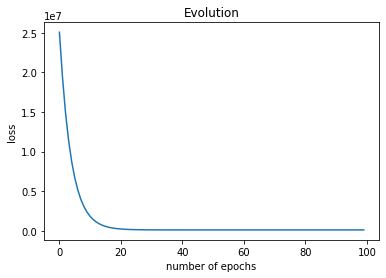

In [78]:
# neural network performances (loss stats)
fig, ax = plt.subplots()
x = np.arange(len(items))
ax.plot(x, items)
# TODO: improve ylabel+title
ax.set(xlabel='number of epochs', ylabel='loss',
       title='Evolution')
plt.show()

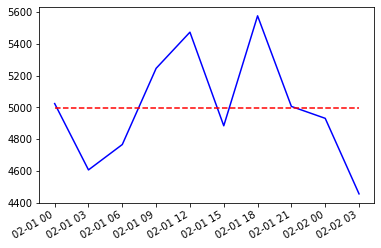

In [79]:
# results
# gca = get current axis
ax = plt.gca()
plt.plot(data_train['Date - Heure'].values, target_data.values, '-', label='True data', color='b')
plt.plot(data_train['Date - Heure'].values, output.detach().numpy(), '--', label='Predictions', color='r')
# plt.plot(data_train['Date - Heure'].values, (output.detach().numpy()+target_data_mean)*target_data_std, '--', label='Predictions', color='r')
plt.gcf().autofmt_xdate()
plt.show()
#(output.detach().numpy()+target_data_mean)*target_data_std